# Data Mining

This notebook applies **K-Means** and **PCA** to identify patterns in the dataset.

Also see:
- [Data Acquisition](./data_acquisition.ipynb)  
- [Exploratory Data Analysis](./eda.ipynb)


In [1]:
!pip install cartopy xarray matplotlib
!pip install netCDF4

from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

## Preprocessing

In [2]:
def preprocessing(feature: str, depth: int):
    # "so" for Salinity, thetao for Semperature
    # 50, 300, 1000 for Depth
    
    ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")
    data = ds[feature].sel(depth=depth, method="nearest")  # → dims: time, lat, lon
    
    # Adding month as a coordinate.
    data = data.assign_coords(month=data["time"].dt.month)
    
    # Calculating the Z-Scores within each month.
    def standardize(group):
        m = group.mean("time")
        s = group.std("time")
        return (group - m) / s
    
    z = data.groupby("month").apply(standardize)  # dims: time, lat, lon
    z = z.stack(location=("latitude", "longitude"))  # dims: time, location (Uniting lat & lon)
    z = z.dropna(dim="location", how="any")   # Removing NaN's
    
    return z.to_pandas()

In [3]:
z_df = preprocessing("thetao", 300)

## Spatial Analysis

### Clustering

In [4]:
from sklearn.cluster import KMeans

# --- 1. Datenmatrix: Orte als Zeilen, Zeitverlauf als Merkmale ---
X = z_df.T.values  # Shape: (n_locations, n_timepoints)

# --- 2. K-means ---
k = 4
kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
labels = kmeans.fit_predict(X)  # Länge = n_locations

# Getting the labels for the dataframe columns.
location_index = z_df.columns  # (lat, lon) tuples
cluster_series = pd.Series(labels, index=location_index, name="cluster")

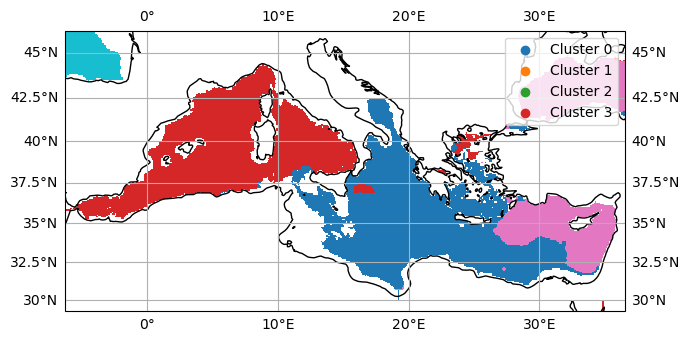

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Data Preparation
cluster_map = cluster_series.unstack()  # Index = lat, columns = lon → shape: (lat, lon)
lat = cluster_map.index.values
lon = cluster_map.columns.values

fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection=ccrs.Mercator())

# Getting the map
mesh = ax.pcolormesh(
    lon, lat, cluster_map.values,
    cmap="tab10",
    transform=ccrs.PlateCarree()
)
ax.coastlines()
ax.gridlines(draw_labels=True)

# Legend
for cluster_id in np.unique(labels):
    plt.scatter([], [], c=[plt.cm.tab10(cluster_id)], label=f"Cluster {cluster_id}")
plt.legend(title="", loc="upper right")

plt.tight_layout()
plt.show()

### Dimensionality Reduction

In [6]:
def pca_plot(data, figsize, legend_loc):

    X_pca = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10", s=10)

    # Extracting the labels for the legend
    for cluster_id in np.unique(labels):
        plt.scatter([], [], c=[plt.cm.tab10(cluster_id)], label=f"Cluster {cluster_id}")
    plt.legend(title="", loc= legend_loc)

    plt.xlabel("PCA-Component 1")
    plt.ylabel("PCA-Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

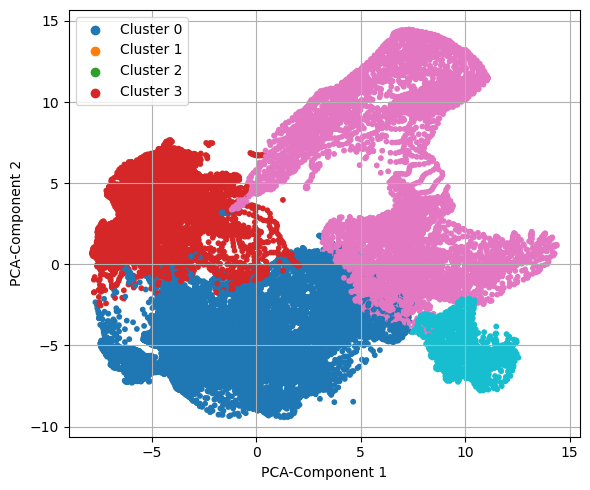

In [7]:
pca_plot(X, (6,5), None)

## Temporal Analysis

### Clustering

In [8]:
X = z_df.values  # Shape: (n_timepoints, n_locations)

print(X.shape)           # → sollte (n_timepoints, n_locations) sein
print(len(z_df.index))   # → sollte == X.shape[0]


kmeans = KMeans(n_clusters=6, n_init="auto", random_state=0)
labels = kmeans.fit_predict(X)  # Jetzt Länge = 108 (Anzahl Zeitpunkte)
labels+=1
cluster_series = pd.Series(labels, index=z_df.index, name="cluster")



time_index = z_df.index  # → this will be the months/timestamps
cluster_series = pd.Series(labels, index=time_index, name="cluster")

(342, 31973)
342


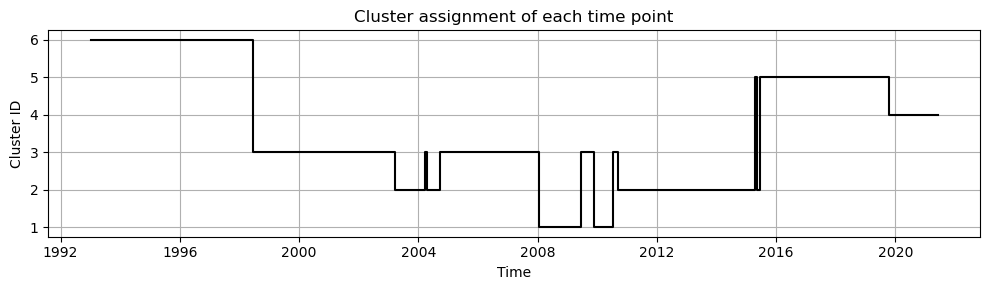

In [9]:
plt.figure(figsize=(10, 3))
plt.plot(cluster_series.index, cluster_series.values, drawstyle='steps-mid', color="black")

plt.yticks(np.arange(cluster_series.min(), cluster_series.max() + 1))
plt.xlabel("Time")
plt.ylabel("Cluster ID")
plt.title("Cluster assignment of each time point")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Colorbar limits (can be auto)
cmin = -1
cmax = -1

# Unstack and assign cluster labels to z-scores
z_unstacked = z.unstack("location")  # → dims: time, latitude, longitude
z_unstacked = z_unstacked.assign_coords(cluster=("time", labels))
z_unstacked = z_unstacked.assign_coords({
    "latitude": z_unstacked.latitude.values.astype(np.float32),
    "longitude": z_unstacked.longitude.values.astype(np.float32)
})

# Compute average z-score map per cluster
cluster_maps = {}
for cluster_id in np.unique(labels):
    avg_map = z_unstacked.where(z_unstacked.cluster == cluster_id).mean("time")
    cluster_maps[cluster_id] = avg_map

# Sort clusters by ID (to ensure order 0→5 or 1→6)
sorted_ids = sorted(cluster_maps.keys())
cluster_maps_ordered = [cluster_maps[i] for i in sorted_ids]

# Determine global color scale range
vmin = -1 if cmin == -1 else min([m.min().item() for m in cluster_maps_ordered])
vmax = 1 if cmax == -1 else max([m.max().item() for m in cluster_maps_ordered])

# Grid layout
n_clusters = len(cluster_maps_ordered)
ncols = 3
nrows = int(np.ceil(n_clusters / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(2.5 * ncols, 1.5 * nrows),
                         subplot_kw={'projection': ccrs.Mercator()})
axes = axes.flatten()

# Plot each cluster
for i, (ax, data_cluster) in enumerate(zip(axes, cluster_maps_ordered)):
    im = data_cluster.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )
    ax.coastlines()
    ax.set_title("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Label with cluster ID (1-based)
    ax.text(
        0.03, 0.03, str(sorted_ids[i] + 1),  # from 1 to 6
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold',
        color='black',
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', edgecolor='none', pad=2, alpha=0.6)
    )

# Hide empty subplots
for ax in axes[len(cluster_maps_ordered):]:
    ax.set_visible(False)

# One shared colorbar
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Z-score")

# Adjust layout
fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0, right=1, top=0.98, bottom=0.12)
plt.show()


NameError: name 'z' is not defined

### Dimensionality Reduction

In [ ]:
pca_plot(X, (10,5), "best")

# Clustering the Temperature and Salinity